# Pipeline for the anomaly detection on the SKAB using SST-detector

Based on https://github.com/waico/SKAB

In [1]:
import sys
sys.path.append(r"...\Fedot.Industrial")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tsad.evaluating.evaluating import evaluating


from cases.anomaly_detection.SSTdetector import SingularSpectrumTransformation
from cases.anomaly_detection.WSSAlgorithms import WindowSizeSelection

# Data Loading

In [2]:
# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk(r"...\SKAB\data"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

In [3]:
# datasets with anomalies loading
list_of_df = [pd.read_csv(file, 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True) for file in all_files if 'anomaly-free' not in file]
# anomaly-free df loading
anomaly_free_df = pd.read_csv([file for file in all_files if 'anomaly-free' in file][0], 
                            sep=';', 
                            index_col='datetime', 
                            parse_dates=True)

# Data description and visualization

In [4]:
# dataset characteristics printing
print(f'A number of datasets in the SkAB v1.0: {len(list_of_df)}\n')
print(f'Shape of the random dataset: {list_of_df[0].shape}\n')
n_cp = sum([len(df[df.changepoint==1.]) for df in list_of_df])
n_outlier = sum([len(df[df.anomaly==1.]) for df in list_of_df])
print(f'A number of changepoints in the SkAB v1.0: {n_cp}\n')
print(f'A number of outliers in the SkAB v1.0: {n_outlier}\n')
print(f'Head of the random dataset:')
display(list_of_df[0].head())

A number of datasets in the SkAB v1.0: 34

Shape of the random dataset: (745, 10)

A number of changepoints in the SkAB v1.0: 129

A number of outliers in the SkAB v1.0: 13067

Head of the random dataset:


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-01 15:44:06,0.082065,0.133521,1.27794,0.054711,92.2562,22.2577,209.639,76.0197,0.0,0.0
2020-03-01 15:44:07,0.082724,0.132378,1.12118,-0.273216,92.0144,22.2577,221.250,76.9806,0.0,0.0
2020-03-01 15:44:08,0.081648,0.139038,1.93242,0.054711,92.2413,22.2748,236.615,76.0197,0.0,0.0
2020-03-01 15:44:09,0.083335,0.132742,1.25962,-0.273216,92.2438,22.2657,230.375,77.0000,0.0,0.0
2020-03-01 15:44:10,0.082272,0.133171,1.59773,0.054711,92.3611,22.2591,249.701,77.0000,0.0,0.0


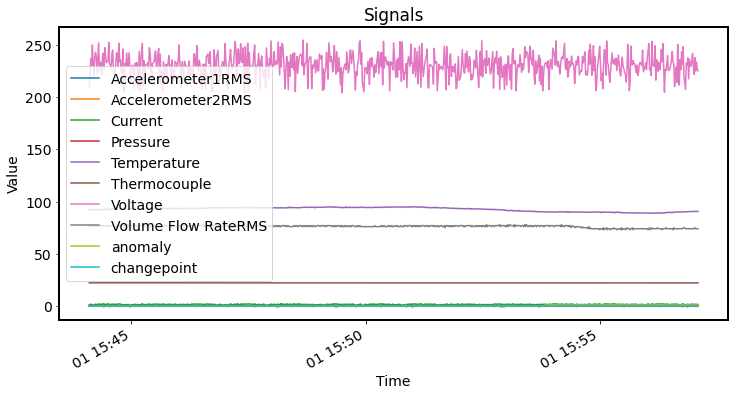

In [5]:
# random dataset visualizing
list_of_df[0].plot(figsize=(12,6))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Signals')
plt.show()

# Labels

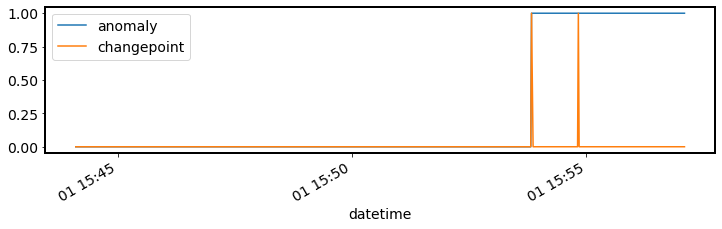

In [6]:
# plotting the labels both for outlier and changepoint detection problems
list_of_df[0].anomaly.plot(figsize=(12,3))
list_of_df[0].changepoint.plot()
plt.legend()
plt.show()

# Method applying

In [7]:
def window_size_selection(ts):
    scorer = WindowSizeSelection(time_series = ts, wss_algorithm='highest_autocorrelation')
    window_size_selected, score = scorer.runner_wss()
    if window_size_selected%2 != 0:
        window_size_selected = window_size_selected + 1
    return window_size_selected

def change_point_detection(ts, lag, dynamic_mode, quantile_rate):
    ts_window_length = window_size_selection(ts)
    trajectory_window_length = window_size_selection(ts[:ts_window_length])
    scorer = SingularSpectrumTransformation(time_series = np.array(ts),
                                            ts_window_length = ts_window_length,
                                            lag = lag,
                                            trajectory_window_length = trajectory_window_length)
    score = scorer.score_offline(dynamic_mode=dynamic_mode)
    return score

In [8]:
Q = 0.999 # quantile for upper control limit (UCL) selection

predicted_cp = []
columns = list_of_df[0].drop(['anomaly', 'changepoint'], axis=1).columns
for df in list_of_df:
    ts = list(df['Voltage'])
    result = change_point_detection(ts, lag=10, dynamic_mode=True, quantile_rate=Q)
    df['results'] = result + [0]
    predicted_cp.append(df['results'])

In [9]:
# true changepoint indices selection
true_cp = [df.changepoint for df in list_of_df]

# Results

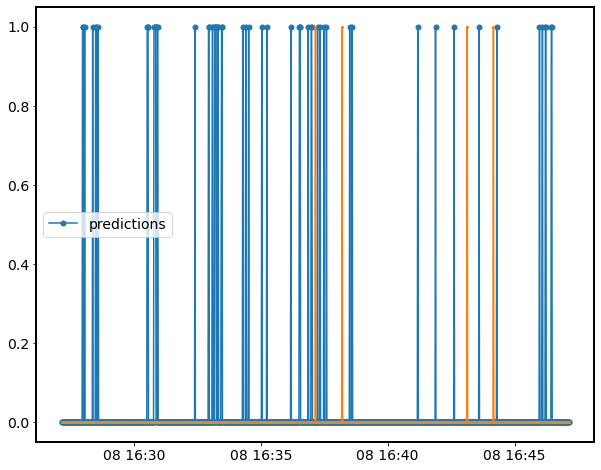

In [10]:
plt.plot(predicted_cp[10],label='predictions', marker='o', markersize=5)
plt.plot(true_cp[10], marker='o', markersize=2)
plt.legend();

# Metrics calculation

In [11]:
# nab metric calculation
nab = evaluating(true_cp, predicted_cp, metric='nab', numenta_time='30 sec')

Intersection of scoring windows(Timestamp('2020-02-08 18:20:42'), Timestamp('2020-02-08 18:20:16'))
Intersection of scoring windows(Timestamp('2020-02-08 18:51:37'), Timestamp('2020-02-08 18:51:25'))
Intersection of scoring windows(Timestamp('2020-02-08 19:26:28'), Timestamp('2020-02-08 19:26:07'))
Intersection of scoring windows(Timestamp('2020-02-08 17:17:12'), Timestamp('2020-02-08 17:16:43'))
Intersection of scoring windows(Timestamp('2020-02-08 17:24:11'), Timestamp('2020-02-08 17:23:44'))
Standart  -  -36.01
LowFP  -  -109.76
LowFN  -  -9.02


In [12]:
# average detection delay metric calculation
add = evaluating(true_cp, predicted_cp, metric='average_time', numenta_time='30 sec')

Intersection of scoring windows(Timestamp('2020-02-08 18:20:42'), Timestamp('2020-02-08 18:20:16'))
Intersection of scoring windows(Timestamp('2020-02-08 18:51:37'), Timestamp('2020-02-08 18:51:25'))
Intersection of scoring windows(Timestamp('2020-02-08 19:26:28'), Timestamp('2020-02-08 19:26:07'))
Intersection of scoring windows(Timestamp('2020-02-08 17:17:12'), Timestamp('2020-02-08 17:16:43'))
Intersection of scoring windows(Timestamp('2020-02-08 17:24:11'), Timestamp('2020-02-08 17:23:44'))
Amount of true anomalies 129
A number of missed CPs = 71
A number of FPs = 1711
Average time 0 days 00:00:19.637931034
